<a href="https://colab.research.google.com/github/anyuanay/INFO371/blob/main/INFO371_Week4_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 4: Decision Tree
### Prof. Y. An, PhD
### College of Computing and Informatics, Drexel University

# Import packages

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

# Error Rate, Entropy, Gini Index
Measuring the uncertainty of an event with a probability

In [2]:
# Given a vector of probabilties
x = np.arange(0.01, 1.01, 0.01)
x

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [3]:
# Compute the uncertainties represented by different measures
import math
er = 1 - np.maximum(x, (1-x))
gini = (x*(1-x) + (1-x)*x)
entropy = -x * np.log2(x) - (1-x)*np.log2(1-x)

<ipython-input-3-f2c39fbf7385>:5: RuntimeWarning: divide by zero encountered in log2
  entropy = -x * np.log2(x) - (1-x)*np.log2(1-x)
<ipython-input-3-f2c39fbf7385>:5: RuntimeWarning: invalid value encountered in multiply
  entropy = -x * np.log2(x) - (1-x)*np.log2(1-x)


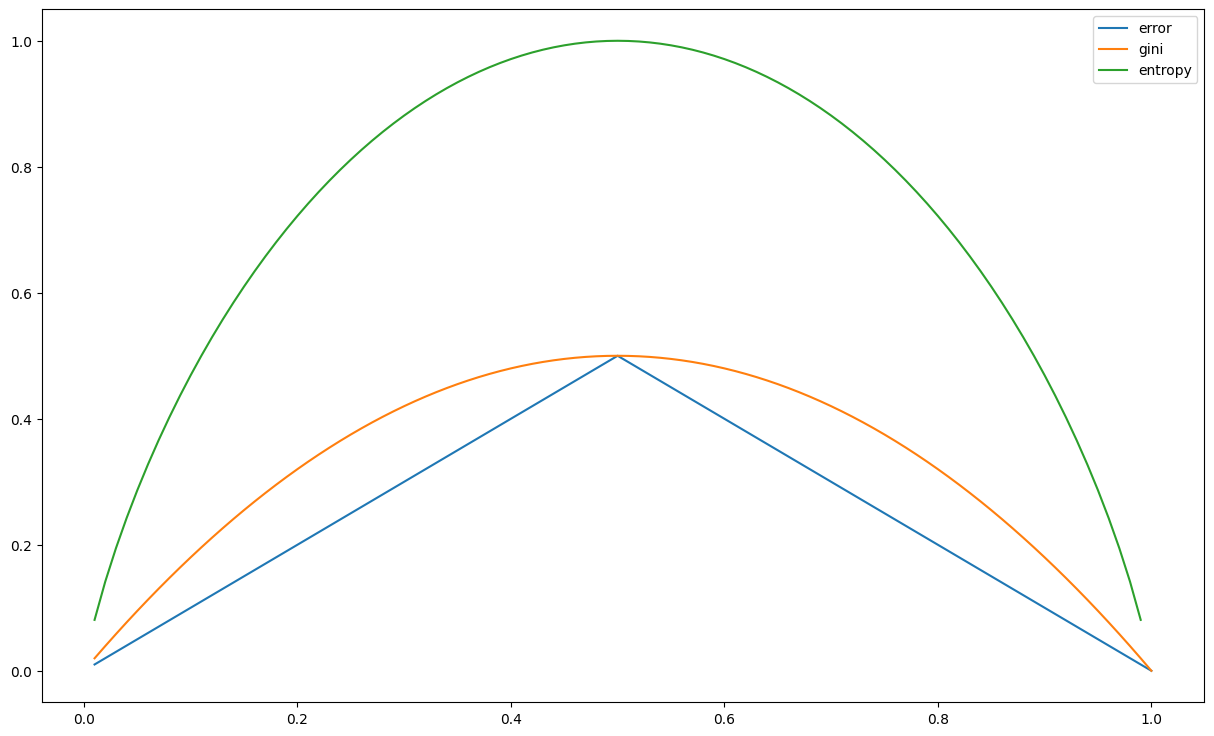

In [4]:
# Plot the uncertaintiies
plt.figure(figsize=(15, 9))
plt.plot(x, er, label="error")
plt.plot(x,gini, label="gini")
plt.plot(x, entropy, label="entropy")
plt.legend()

# Compute Information Gain
A data set with 4 triangles, 4 circles, and 2 rectangles, split into two subsets:
- 3 triangles, 2 circles, and 1 rectangle
- 1 triangle, 2 circles, and 1 rectangle

Compute the entropy, gini index, information gain, respectivly

In [5]:
entropy_442 = -((4/10) * math.log2(4/10) + (4/10) * math.log2(4/10) + (2/10) * math.log2(2/10))

In [6]:
entropy_442

1.5219280948873621

In [7]:
gini_442 = (4/10) * (1-4/10) + (4/10) * (1-4/10) + (2/10) * (1-2/10)

In [8]:
gini_442

0.64

In [9]:
entropy_321 = -((3/6)*math.log2(3/6) + (2/6)*math.log2(2/6)+(1/6)*math.log2(1/6))
entropy_321

1.4591479170272448

In [10]:
gini_321 = (3/6*(1-3/6))+(2/6)*(1-2/6)+(1/6)*(1-1/6)
gini_321

0.6111111111111112

In [11]:
entropy_121 = -((1/4)*math.log2(1/4) + (2/4)*math.log2(2/4)+(1/6)*math.log2(1/4))
entropy_121

1.3333333333333333

In [12]:
gini_121 = (1/4*(1-1/4))+(2/4)*(1-2/4)+(1/4)*(1-1/4)
gini_121

0.625

In [13]:
entropy_subsets = (6/10) * entropy_321 + (4/10) * entropy_121

In [14]:
entropy_subsets

1.4088220835496803

In [15]:
info_gain_entropy = entropy_442 - entropy_subsets
info_gain_entropy

0.11310601133768183

In [16]:
info_gain_gini = gini_442 - ((6/10) * gini_321 + (4/10) * gini_121)
info_gain_gini

0.023333333333333317

# Predict play or not depending on the weather condition

In [56]:
files.upload()

Saving weather_nominal_train.csv to weather_nominal_train.csv


{'weather_nominal_train.csv': b'outlook,temperature,humidity,windy,play\nsunny,hot,high,FALSE,no\nsunny,hot,high,TRUE,no\novercast,hot,high,FALSE,yes\nrainy,mild,high,FALSE,yes\nrainy,cool,normal,FALSE,yes\nrainy,cool,normal,TRUE,no\novercast,cool,normal,TRUE,yes\nsunny,mild,high,FALSE,no\nsunny,cool,normal,FALSE,yes\nrainy,mild,normal,FALSE,yes\nsunny,mild,normal,TRUE,yes\novercast,mild,high,TRUE,yes\novercast,hot,normal,FALSE,yes\nrainy,mild,high,TRUE,no\n'}

In [57]:
play = pd.read_csv("weather_nominal.csv")
play

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


# Extract training attributes X and target y

In [58]:
X = play[['outlook', 'temperature', 'humidity', 'windy']]
y = play['play']

In [59]:
X

,outlook,temperature,humidity,windy
0,sunny,hot,high,False
1,sunny,hot,high,True
2,overcast,hot,high,False
3,rainy,mild,high,False
4,rainy,cool,normal,False
5,rainy,cool,normal,True
6,overcast,cool,normal,True
7,sunny,mild,high,False
8,sunny,cool,normal,False
9,rainy,mild,normal,False


In [60]:
y

,play
0,no
1,no
2,yes
3,yes
4,yes
5,no
6,yes
7,no
8,yes
9,yes


In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
dt = DecisionTreeClassifier()

In [24]:
dt.fit(X,y)

ValueError: could not convert string to float: 'sunny'

# Encode string values to numbers

In [61]:
from sklearn.preprocessing import OrdinalEncoder

In [64]:
xencoder = OrdinalEncoder()
xencoder.fit(X)

OrdinalEncoder()

In [65]:
X_train = xencoder.transform(X)

In [66]:
X_train

array([[2., 1., 0., 0.],
       [2., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 2., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 0., 0.],
       [2., 0., 1., 0.],
       [1., 2., 1., 0.],
       [2., 2., 1., 1.],
       [0., 2., 0., 1.],
       [0., 1., 1., 0.],
       [1., 2., 0., 1.]])

In [67]:
from sklearn.preprocessing import LabelEncoder

In [68]:
yencorder = LabelEncoder()
yencorder.fit(y)

LabelEncoder()

In [69]:
#y_train = y.map({"yes":0, "no":1})
y_train = yencorder.transform(y)
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

# import the DecisionTreeClassifier

In [70]:
from sklearn.tree import DecisionTreeClassifier

# Fit a Decision Tree

In [71]:
dt = DecisionTreeClassifier()

In [72]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

# Visualize Decision Tree

In [ ]:
!pip install -q dtreeviz

In [ ]:
import dtreeviz

In [ ]:
viz = dtreeviz.model(dt,
               X_train,
               y_train,
               target_name='play',
               feature_names=X.columns,
               class_names=["yes", "no"])

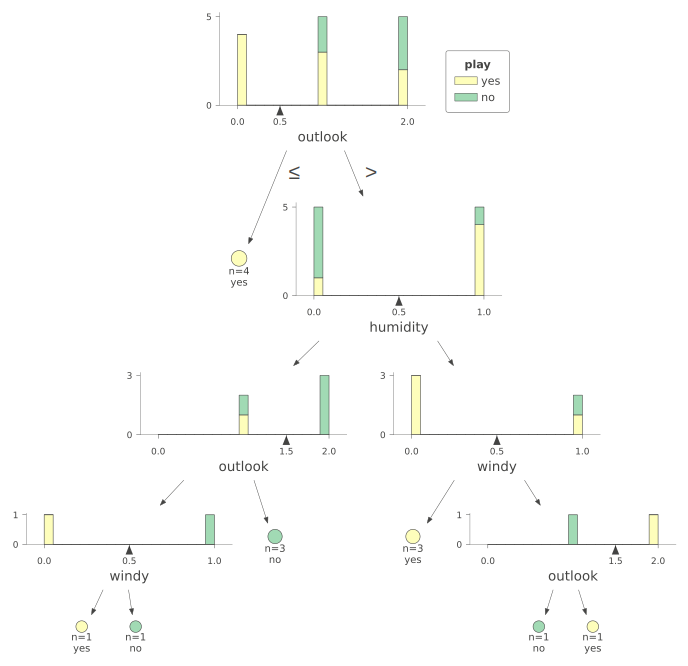

In [ ]:
viz.view(scale=1.5)

In [35]:
from sklearn import tree
text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_0 <= 0.50
|   |--- class: 1
|--- feature_0 >  0.50
|   |--- feature_2 <= 0.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: 0
|   |--- feature_2 >  0.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_3 >  0.50
|   |   |   |--- feature_1 <= 1.00
|   |   |   |   |--- class: 0
|   |   |   |--- feature_1 >  1.00
|   |   |   |   |--- class: 1



[Text(0.4, 0.9, 'x[0] <= 0.5\ngini = 0.459\nsamples = 14\nvalue = [5, 9]'),
 Text(0.3, 0.7, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.35, 0.8, 'True  '),
 Text(0.5, 0.7, 'x[2] <= 0.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.45, 0.8, '  False'),
 Text(0.3, 0.5, 'x[0] <= 1.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.2, 0.3, 'x[3] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.7, 0.5, 'x[3] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.8, 0.3, 'x[1] <= 1.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

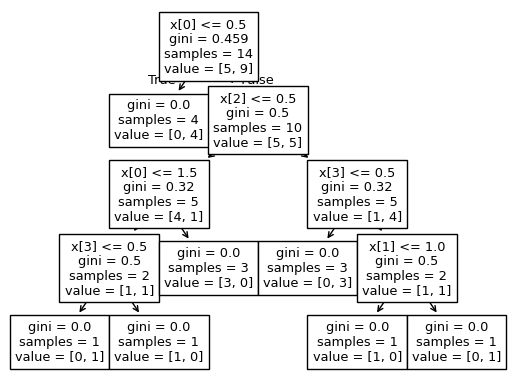

In [36]:
from sklearn import tree
tree.plot_tree(dt)

## Evaluate Performance on Test Data

In [73]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [84]:
files.upload()

Saving weather_nominal_test.csv to weather_nominal_test.csv


{'weather_nominal_test.csv': b'outlook,temperature,humidity,windy,play\nsunny,cool,normal,FALSE,yes\novercast,hot,normal,FALSE,yes\nrainy,hot,high,FALSE,no\nsunny,cool,normal,TRUE,no\novercast,cool,normal,TRUE,no\nrainy,cool,high,TRUE,yes\n'}

In [85]:
test = pd.read_csv("weather_nominal_test.csv")
test

,outlook,temperature,humidity,windy,play
0,sunny,cool,normal,False,yes
1,overcast,hot,normal,False,yes
2,rainy,hot,high,False,no
3,sunny,cool,normal,True,no
4,overcast,cool,normal,True,no
5,rainy,cool,high,True,yes


In [86]:
X_test_label = test[['outlook', 'temperature', 'humidity', 'windy']]
y_test_label = test['play']

In [87]:
X_test = xencoder.transform(X_test_label)
y_test = yencorder.transform(y_test_label)

In [88]:
accuracy_score(y_test, dt.predict(X_test))

0.5

In [90]:
precision_recall_fscore_support(y_test, dt.predict(X_test))

(array([0.5, 0.5]),
 array([0.33333333, 0.66666667]),
 array([0.4       , 0.57142857]),
 array([3, 3]))

# One Hot Encoding

In [91]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
xoneHot = OneHotEncoder()
xoneHot.fit(X)

OneHotEncoder()

In [93]:
xoneHot.categories_

[array(['overcast', 'rainy', 'sunny'], dtype=object),
 array(['cool', 'hot', 'mild'], dtype=object),
 array(['high', 'normal'], dtype=object),
 array([False,  True])]

In [94]:
xoneHot.transform(X).toarray()

array([[0., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.]])

In [95]:
xoneHot.get_feature_names_out(['outlook', 'temperature', 'humidity', 'windy'])

array(['outlook_overcast', 'outlook_rainy', 'outlook_sunny',
       'temperature_cool', 'temperature_hot', 'temperature_mild',
       'humidity_high', 'humidity_normal', 'windy_False', 'windy_True'],
      dtype=object)

In [96]:
X

,outlook,temperature,humidity,windy
0,sunny,hot,high,False
1,sunny,hot,high,True
2,overcast,hot,high,False
3,rainy,mild,high,False
4,rainy,cool,normal,False
5,rainy,cool,normal,True
6,overcast,cool,normal,True
7,sunny,mild,high,False
8,sunny,cool,normal,False
9,rainy,mild,normal,False


In [98]:
X_1hot = xoneHot.transform(X).toarray()
X_1hot

array([[0., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.]])

In [99]:
dt_1hot = DecisionTreeClassifier(min_samples_leaf=2)
dt_1hot.fit(X_1hot, y_train)

DecisionTreeClassifier(min_samples_leaf=2)

In [ ]:
viz = dtreeviz.model(dt_1hot,
               X_1hot,
               y_train,
               target_name='play',
               feature_names=X_1hot.columns,
               class_names=["yes", "no"]
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.11/dist-packages/dtreeviz/models/shadow_decision_tree.py:291: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7078: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7093: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


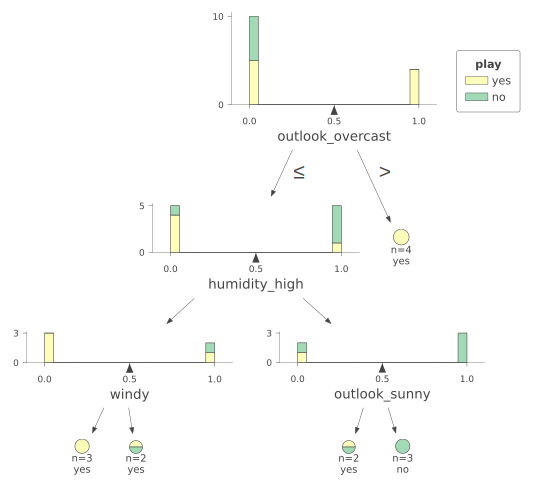

In [ ]:
viz.view(scale=1.5)

# Evaluate the performance

In [100]:
X_1hot_test = xoneHot.transform(X_test_label).toarray()

In [101]:
accuracy_score(y_test, dt_1hot.predict(X_1hot_test))

0.6666666666666666

In [102]:
precision_recall_fscore_support(y_test, dt_1hot.predict(X_1hot_test))

(array([0.66666667, 0.66666667]),
 array([0.66666667, 0.66666667]),
 array([0.66666667, 0.66666667]),
 array([3, 3]))

## Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
rf = RandomForestClassifier(n_estimators=100)

In [105]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [106]:
accuracy_score(y_test, rf.predict(X_test))

0.5

In [107]:
precision_recall_fscore_support(y_test, rf.predict(X_test))

(array([0.5, 0.5]),
 array([0.33333333, 0.66666667]),
 array([0.4       , 0.57142857]),
 array([3, 3]))

In [108]:
rf_1hot = RandomForestClassifier(n_estimators=100)
rf_1hot.fit(X_1hot, y_train)

RandomForestClassifier()

In [109]:
accuracy_score(y_test, rf_1hot.predict(X_1hot_test))

0.3333333333333333

In [110]:
precision_recall_fscore_support(y_test, rf_1hot.predict(X_1hot_test))

(array([0. , 0.4]),
 array([0.        , 0.66666667]),
 array([0. , 0.5]),
 array([3, 3]))